# Wasserstein Geometry

## Introduction 
The goal of this notebook is to show how to interpolate between two points in Wasserstein Space using the idea of Wasserstein Barycenters! First we will show an example of two distribution, and what it means to "interpolate" between them. 

In [1]:
from src.bcmap import *
import src.data as data
from matplotlib import cm
import seaborn as sns 
from scipy.stats import beta
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

## Interpolating Between Distributions
This animation visualizes how we can use the Wasserstein distance to go from one distribution to another.  What we show below is interpolation in "Wasserstein Space."  What the Wasserstein interpolation shows us, is the most efficient way of transforming one distribution into the other. 

<img src="./img/figure1.gif" width="750" align="center">

## How to Interpolate 
The above animation shows interpolation in the continuous setting where we have full distributions.  In general, we look to solve the problem over discrete spaces where we only have scores, which which can think of as samples from the some distribution. 

### Demonstrating w/ Compas
To demonstrate interpolation, we will begin with the Compas Dataset. The cell below produces a scatter plot showing the distribution of risk scores for each group. Along the x-axis are the risk scores, and along the y-axis, is the percentile of that risk score.  For example the point (7,0.63) means that for some group, 63% of the defedandants in that group had a score of 7 or lower. 

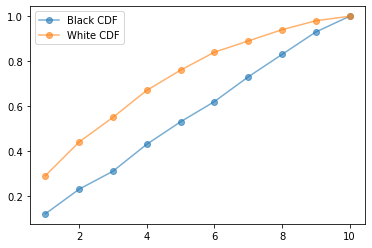

In [2]:
B = "African-American"
W = "Caucasian"

#Possible range of scores is 1-10 
bins = np.arange(1, 11)

#Get dataframe from dataloader -- use .sample() to shuffle the order of the data 
df = data.compas().sample(frac=1)
n = len(df)
alpha = 1

#Train Test Split 
split_ix = int(n * alpha)

df_train = df.iloc[:split_ix]
df_test = df.iloc[split_ix:]

#Seperate training data by attribute 
black_train = df_train[df_train[B] == True]
white_train = df_train[df_train[W] == True]

min_n = min(len(black_train),len(white_train))
black_train = black_train.iloc[:min_n]
white_train = white_train.iloc[:min_n]

df_train = pd.concat([black_train, white_train])


black_CDF = empiricalCDF(black_train["decile_score"].to_numpy(), bins=bins)
white_CDF = empiricalCDF(white_train["decile_score"].to_numpy(), bins=bins)

alpha=.6
plt.plot(bins, black_CDF,"-o", alpha=alpha, label="Black CDF")
plt.plot(bins, white_CDF,"-o", alpha=alpha, label="White CDF")
plt.legend()

This cell contains the method which computes the geometric repair. It returns the barycenter with the repaired scores which will appear in the column corresponding to the argument "repaired_col"

In [3]:
repaired, bc = geometric_adjustment(train_df=df_train,
                         test_df=df_train,
                         sens_col=B,
                         score_col="decile_score",
                         solver="bregman",
                         bins=bins,
                         return_barycenter=True)
repaired.head()

,sex,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,is_violent_recid,...,c_jail_time,custody_length,Other,African-American,Caucasian,Hispanic,Asian,Native American,repaired_score,shift
6239,0,29,0,10,0,0,1,0,0,0,...,15.638056,0.0,False,False,True,False,False,False,10,0
5786,0,35,0,2,0,0,0,1,0,0,...,14.305556,1.0,False,False,True,False,False,False,2,0
1208,0,38,0,4,0,0,0,1,0,0,...,159.483611,158.0,False,False,True,False,False,False,5,1
1820,0,32,0,7,0,2,6,0,0,0,...,4.166667,0.0,False,False,True,False,False,False,8,1
839,0,56,0,1,0,0,4,0,1,0,...,6.134167,0.0,False,False,True,False,False,False,1,0


Here is a visualiation of the repaired scores as CDFs

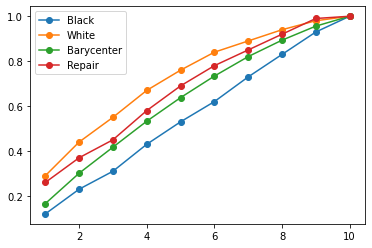

In [4]:
bc_cdf = np.cumsum(bc)
repaired_cdf = empiricalCDF(repaired["repaired_score"].to_numpy(), bins=bins)
plt.plot(bins, black_CDF, "-o", label="Black")
plt.plot(bins, white_CDF, "-o", label="White")
plt.plot(bins, bc_cdf, "-o", label="Barycenter")
plt.plot(bins, repaired_cdf, "-o", label="Repair")
plt.legend()

Using the repaired scores, we can perform geometric repair, which is the basis for the method.  The geometric repair step is done using the following method, and requires a dataframe with the columns specific by the original_col and shift_col parameters 

In [5]:
interp_df = interpolate(repaired_df = repaired, 
                       original_col = "decile_score",
                       shift_col = "shift",
                       l=0.0)
interp_df.head()

,sex,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,is_violent_recid,...,custody_length,Other,African-American,Caucasian,Hispanic,Asian,Native American,repaired_score,shift,interpolated
6239,0,29,0,10,0,0,1,0,0,0,...,0.0,False,False,True,False,False,False,10,0,10.0
5786,0,35,0,2,0,0,0,1,0,0,...,1.0,False,False,True,False,False,False,2,0,2.0
1208,0,38,0,4,0,0,0,1,0,0,...,158.0,False,False,True,False,False,False,5,1,4.0
1820,0,32,0,7,0,2,6,0,0,0,...,0.0,False,False,True,False,False,False,8,1,7.0
839,0,56,0,1,0,0,4,0,1,0,...,0.0,False,False,True,False,False,False,1,0,1.0


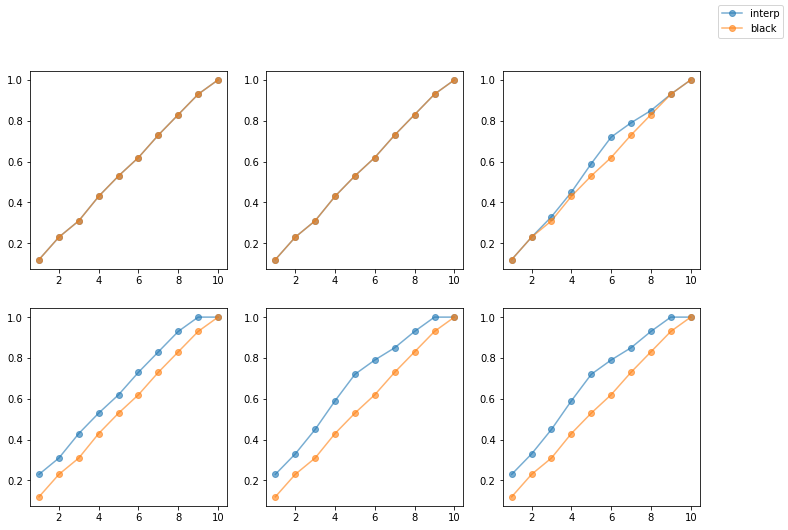

In [6]:
fig, ax = plt.subplots(2,3,figsize=(12,8))
interps = np.linspace(0,1,6)
for i in range(len(interps)): 
    p = interps[i] #get the interpolation value 
    
    #interpolate
    interp_df = interpolate(repaired_df = repaired, 
                       original_col = "decile_score",
                       shift_col = "shift",
                       l=p)
    
    interp_df_black = interp_df[interp_df["African-American"] == True]
    
    #Make CDF 
    interp_cdf =  empiricalCDF(interp_df_black["interpolated"].to_numpy(), bins=bins)
    
    k = int(i/ax.shape[1])
    j = i % 3 
    alpha = .6
    if i == 0:
        ax[k,j].plot(bins, interp_cdf, "-o", label="interp", alpha=alpha)
        ax[k,j].plot(bins, black_CDF, "-o", label="black", alpha=alpha)
    else:
        ax[k,j].plot(bins, interp_cdf, "-o", alpha=alpha)
        ax[k,j].plot(bins, black_CDF, "-o", alpha=alpha)
        
fig.legend()

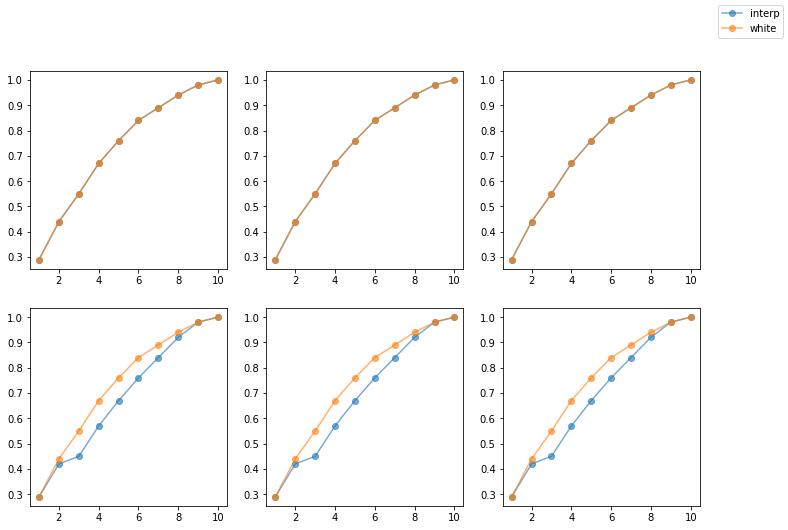

In [7]:
fig, ax = plt.subplots(2,3,figsize=(12,8))
interps = np.linspace(0,1,6)
for i in range(len(interps)): 
    p = interps[i] #get the interpolation value 
    
    #interpolate
    interp_df = interpolate(repaired_df = repaired, 
                       original_col = "decile_score",
                       shift_col = "shift",
                       l=p)
    
    interp_df_white = interp_df[interp_df["Caucasian"] == True]
    
    #Make CDF 
    interp_cdf =  empiricalCDF(interp_df_white["interpolated"].to_numpy(), bins=bins)


    
    k = int(i/ax.shape[1])
    j = i % 3 
    if i == 0:
        ax[k,j].plot(bins, interp_cdf, "-o", label="interp", alpha=alpha)
        ax[k,j].plot(bins, white_CDF, "-o", label="white", alpha=alpha)
    else:
        ax[k,j].plot(bins, interp_cdf, "-o", alpha=alpha)
        ax[k,j].plot(bins, white_CDF, "-o", alpha=alpha)
        
fig.legend()